In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

# 1. IRIS 데이터 로드 및 준비
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['target'] = iris.target

X = data.drop('target', axis=1)
y = data['target']
class_names = iris.target_names

# 2. 파라미터 설정
epochs = 50
batch_size = 8
units= 32 
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# 3. 데이터 분리 (One-to-Rest와 Softmax 모두 동일한 분할 사용)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Label Encoding (One-to-Rest에서 사용)
label_encoder_one_rest = LabelEncoder()
encoded_y_train_one_rest = label_encoder_one_rest.fit_transform(y_train)
encoded_y_test_one_rest = label_encoder_one_rest.transform(y_test)

# One-Hot Encoding (Softmax에서 사용)
onehot_encoder_softmax = OneHotEncoder(sparse_output=False)
onehot_y_train_softmax = onehot_encoder_softmax.fit_transform(y_train.values.reshape(-1, 1))
onehot_y_test_softmax = onehot_encoder_softmax.transform(y_test.values.reshape(-1, 1))

# 4. One-to-Rest 방식으로 구현 및 정확도 측정
print("\n--- One-to-Rest 방식 ---")

accuracies_one_rest = []
models_one_rest = []
histories_one_rest = []  # 훈련 이력 저장 리스트

for i in range(len(class_names)):
    print(f"\n--- 학습: 클래스 '{class_names[i]}' vs 나머지 ---")
    binary_y_train = np.where(encoded_y_train_one_rest == i, 1, 0)
    binary_y_test = np.where(encoded_y_test_one_rest == i, 1, 0)

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)), 
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, binary_y_train, epochs=epochs, batch_size=batch_size, verbose=0, 
                        validation_data=(X_test, binary_y_test))
    loss, accuracy = model.evaluate(X_test, binary_y_test, verbose=0)
    print(f"클래스 '{class_names[i]}' vs 나머지 - 테스트 정확도: {accuracy:.4f}")
    accuracies_one_rest.append(accuracy)
    models_one_rest.append(model)
    histories_one_rest.append(history)

# One-to-Rest 전체 정확도 계산
def predict_one_to_rest(models, data):
    predictions = []
    for model in models:
        proba = model.predict(data)
        predictions.append(proba)
    return np.argmax(np.concatenate(predictions, axis=1), axis=1)

y_pred_one_rest_encoded = predict_one_to_rest(models_one_rest, X_test)
one_to_rest_overall_accuracy = np.mean(y_pred_one_rest_encoded == encoded_y_test_one_rest)
print(f"\nOne-to-Rest 방식 전체 정확도: {one_to_rest_overall_accuracy:.4f}")


--- One-to-Rest 방식 ---

--- 학습: 클래스 'setosa' vs 나머지 ---
클래스 'setosa' vs 나머지 - 테스트 정확도: 1.0000

--- 학습: 클래스 'versicolor' vs 나머지 ---
클래스 'versicolor' vs 나머지 - 테스트 정확도: 0.7000

--- 학습: 클래스 'virginica' vs 나머지 ---
클래스 'virginica' vs 나머지 - 테스트 정확도: 0.9667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

One-to-Rest 방식 전체 정확도: 0.9667


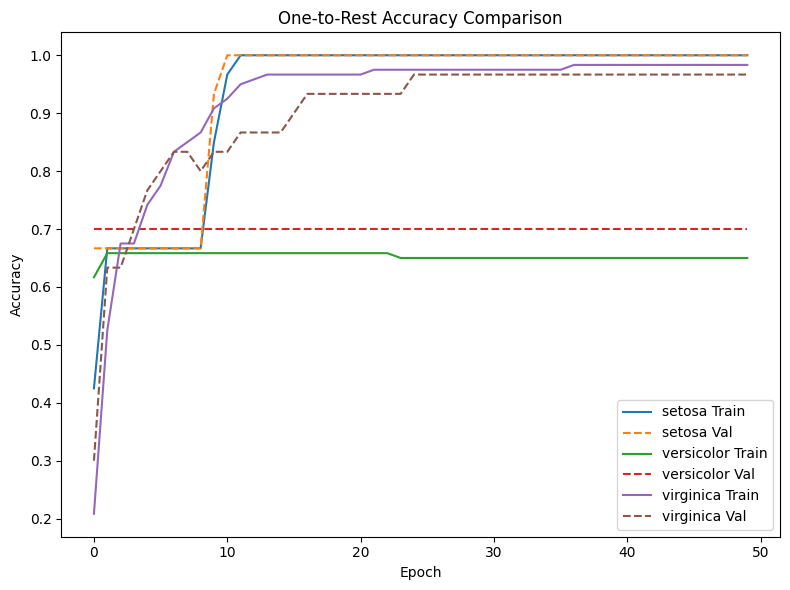

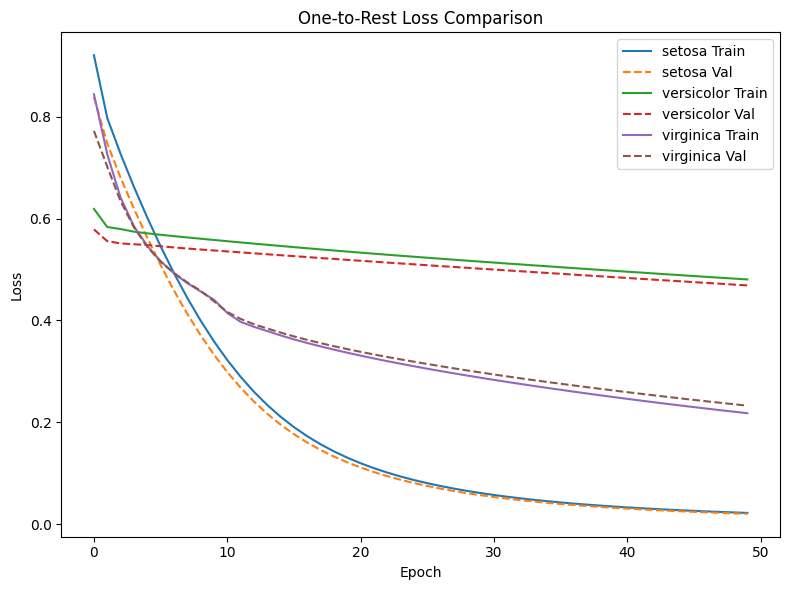

In [15]:
# One-to-Rest 훈련 결과를 Accuracy와 Loss 각각 한 창에서 비교하여 시각화

# Accuracy 비교
plt.figure(figsize=(8, 6))
for i, history in enumerate(histories_one_rest):
    plt.plot(history.history['accuracy'], label=f"{class_names[i]} Train")
    plt.plot(history.history['val_accuracy'], label=f"{class_names[i]} Val", linestyle='--')
plt.title("One-to-Rest Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Loss 비교
plt.figure(figsize=(8, 6))
for i, history in enumerate(histories_one_rest):
    plt.plot(history.history['loss'], label=f"{class_names[i]} Train")
    plt.plot(history.history['val_loss'], label=f"{class_names[i]} Val", linestyle='--')
plt.title("One-to-Rest Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [16]:
# 5. Softmax 방식으로 구현 및 정확도 측정
print("\n--- Softmax 방식 ---")

model_softmax = tf.keras.models.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_softmax = model_softmax.fit(X_train, onehot_y_train_softmax, epochs=epochs, batch_size=batch_size, 
                                    verbose=0, validation_data=(X_test, onehot_y_test_softmax))
loss_softmax, accuracy_softmax = model_softmax.evaluate(X_test, onehot_y_test_softmax, verbose=0)
print(f"Softmax 방식 - 테스트 정확도: {accuracy_softmax:.4f}")


--- Softmax 방식 ---
Softmax 방식 - 테스트 정확도: 1.0000



--- Softmax 훈련 결과 시각화 ---


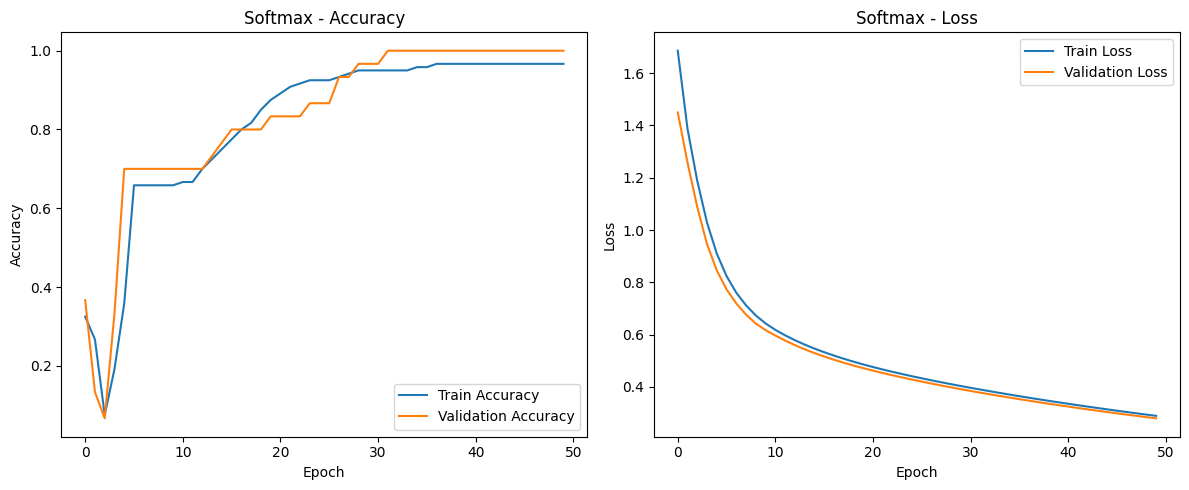

In [17]:
# Softmax 훈련 결과 시각화
print("\n--- Softmax 훈련 결과 시각화 ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_softmax.history['accuracy'], label='Train Accuracy')
plt.plot(history_softmax.history['val_accuracy'], label='Validation Accuracy')
plt.title('Softmax - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_softmax.history['loss'], label='Train Loss')
plt.plot(history_softmax.history['val_loss'], label='Validation Loss')
plt.title('Softmax - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
# 6. 결과 출력 (Pandas DataFrame)
results = pd.DataFrame({
    'Method': ['One-to-Rest', 'Softmax'],
    'Accuracy': [one_to_rest_overall_accuracy, accuracy_softmax]
})

print("\n--- 정확도 결과 (Pandas DataFrame) ---")
print(results)


--- 정확도 결과 (Pandas DataFrame) ---
        Method  Accuracy
0  One-to-Rest  0.966667
1      Softmax  1.000000


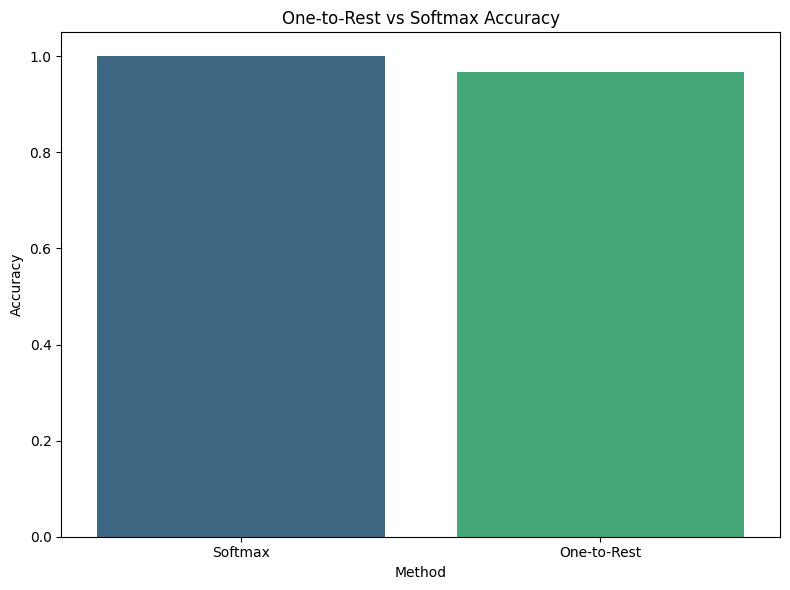

In [19]:
# 7. 정확도 시각화 (Sorting된 Bar Plot)
results_sorted = results.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(8, 6))
#sns.barplot(x='Method', y='Accuracy', data=results_sorted, palette='viridis')
sns.barplot(x='Method', y='Accuracy', hue='Method', data=results_sorted, palette='viridis', legend=False)
plt.title('One-to-Rest vs Softmax Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Method')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()